<a href="https://colab.research.google.com/github/makhai88/CAR_EMISSION/blob/main/Cars_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [39]:
#! pip install --user imblearn

In [40]:
import pandas as pd
import numpy as np
##
import random
##
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from pathlib import Path
import collections
##
import seaborn as sns
import matplotlib.pyplot as plt
##
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
##
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
##
import sklearn.metrics as metrics
from sklearn import preprocessing, model_selection, metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
##
import warnings
warnings.filterwarnings("ignore")
##
%matplotlib inline

# Import CSV

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
path = "/content/drive/My Drive/Colab_Cars_Public/sample201320.csv"
cars_df = pd.read_csv(path, sep=",",dtype = str)

In [43]:
cars_df.head(5)

,RecordID,RECORD_NUM,VIR_CERT_NUMBER,STATION_NUM,ANALYZER_NUM,INSPECTOR_NUM,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,VIN_SOURCE,VEH_LICENSE,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,ESC,VRT_RECORD_ID,E_TEST_SEQUENCE,E_PRECOND_PROCEDURE,E_HIGH_DCF,E_HIGH_RPM,E_HIGH_CO2,E_HIGH_O2,E_HIGH_HC,E_HIGH_HC_DCF,E_HIGH_HC_LIMIT,E_HIGH_CO,...,OBD_RDY_RESULT,OBD_PID,OBD_PCM_ID,OBD_VIN,OBD_FLT_CODES,OBD_FLT_RESULT,OBD_MIL_STATUS,OBD_RESULT,ONLINE_STATUS,OFFLINE_REASON_CODE,ABORT_CODE,SOFTWARE_VERSION,INSP_COMMENTS,OVERALL_RESULT,R_TOTAL_COST,R_EGR,R_ELECTRICAL,R_EVAP_CONTROL,R_EXHAUST,R_IGNITION,R_INTAKE,R_ENGINE,R_PCV,R_OTHER,SentToWW,ABORT_CODE_OTHER_DESC,OBDII_AFFECT_OVERALL,E_HIGH_CO_RESULT,E_HIGH_HC_RESULT,E_IDLE_CO_RESULT,E_IDLE_HC_RESULT,MECHANIC_LAST_NAME,MECHANIC_FIRST_NAME,MECHANIC_MIDDLE_INIT,ENGINE_SIZE_ORIG,FAILED_IDLE_RPM,SENTTOVID,Station_License_Number,Analyzer_Number,Insert_DateTime
0,2728181,1871,06908600,IS441,W148,22013821,I,I,2013-04-16 13:10:00,2013-04-16 13:13:00,4C3AU52NXWE133832,S,JTM00,1,3250,1998,CHRYSLER,SEBRING,6,2500,A,N,109025,G,1,15.98,87108,F,6,980033,1,1,0,0,0,0,0,0,100,0,...,P,23,41,NaN,NaN,P,1,P,1,0,NaN,0502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,BRILLON,JENNIFER,D,NaN,NaN,0,IS441,W148,2013-04-16 12:13:04
1,2812480,10414,06988927,IS341,W021,32480268,I,I,2013-08-01 11:02:00,2013-08-01 11:05:00,2FMZA51402BB70021,S,KWC774,1,5650,2002,FORD,WINDSTAR 4DR,6,3800,A,N,167508,G,5,17.00,87105,N,20,20020770,1,1,0,0,0,0,0,0,100,0,...,P,20,10,NaN,NaN,P,1,P,1,0,NaN,0502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,MIRABAL,ROSALIA,C,NaN,NaN,0,IS341,W021,2013-08-01 15:18:44
2,2822257,15560,06992350,IS404,W042,AC083846,I,I,2013-08-14 09:25:00,2013-08-14 09:29:00,WMWRF33566TG13861,S,MAJ448,1,0,2006,MINI,COOPER,4,1600,A,N,18275,G,1,17.00,87111,C,6,0,1,1,0,0,0,0,0,0,100,0,...,P,18,13,WMWRF33566TG13861,NaN,P,1,P,1,0,NaN,0502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,NGUYEN,ANPHA,T,1.6L,NaN,0,IS404,W042,2013-08-14 16:23:59
3,2824438,15392,06966912,IS296,W050,AC084285,I,I,2013-08-17 10:55:00,2013-08-17 10:59:00,1FALP6537TK218840,S,NP218840,1,3125,1996,FORD,CONTOUR,4,2000,A,N,148253,G,1,24.99,87120,F,6,961077,1,1,0,0,0,0,0,0,100,0,...,P,16,10,NaN,NaN,P,1,P,1,0,NaN,0502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,Romero,Sante,M,NaN,NaN,0,IS296,W050,2013-08-17 09:58:32
4,2711421,2577,06887248,IS425,W098,21369207,I,I,2013-03-27 11:59:00,2013-03-27 12:03:00,1N4AL11D73C215791,S,DGW726,1,3375,2003,NISSAN,ALTIMA,4,2500,M,N,118937,G,1,21.00,87109,C,6,20030424,1,1,0,0,0,0,0,0,100,0,...,P,18,10,NaN,NaN,P,1,P,1,0,NaN,0502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,LOPEZ,CAMILO,D,NaN,NaN,0,IS425,W098,2013-03-27 16:33:17


In [44]:
# select columns based on domain knowledge
cols = ['RecordID','VIN','GVWR','MODEL_YEAR','MAKE','MODEL','CYL','ENGINE_SIZE','TRANS_TYPE','DUAL_EXHAUST','ODOMETER','FUEL_TYPE','OVERALL_RESULT','TEST_EDATE']
cars_sample= cars_df[cols]
cars_sample.head()

,RecordID,VIN,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,OVERALL_RESULT,TEST_EDATE
0,2728181,4C3AU52NXWE133832,3250,1998,CHRYSLER,SEBRING,6,2500,A,N,109025,G,P,2013-04-16 13:13:00
1,2812480,2FMZA51402BB70021,5650,2002,FORD,WINDSTAR 4DR,6,3800,A,N,167508,G,P,2013-08-01 11:05:00
2,2822257,WMWRF33566TG13861,0,2006,MINI,COOPER,4,1600,A,N,18275,G,P,2013-08-14 09:29:00
3,2824438,1FALP6537TK218840,3125,1996,FORD,CONTOUR,4,2000,A,N,148253,G,P,2013-08-17 10:59:00
4,2711421,1N4AL11D73C215791,3375,2003,NISSAN,ALTIMA,4,2500,M,N,118937,G,P,2013-03-27 12:03:00


In [45]:
cars_sample.shape

(188856, 14)

In [46]:
cars_sample.dtypes

RecordID          object
VIN               object
GVWR              object
MODEL_YEAR        object
MAKE              object
MODEL             object
CYL               object
ENGINE_SIZE       object
TRANS_TYPE        object
DUAL_EXHAUST      object
ODOMETER          object
FUEL_TYPE         object
OVERALL_RESULT    object
TEST_EDATE        object
dtype: object

In [47]:
cars_sample.OVERALL_RESULT.value_counts()

P    169820
F     13354
A      5678
O         3
Name: OVERALL_RESULT, dtype: int64

In [48]:
cars_sample.isnull().sum()

RecordID             0
VIN                  0
GVWR                 0
MODEL_YEAR           0
MAKE               900
MODEL              903
CYL                936
ENGINE_SIZE          0
TRANS_TYPE         937
DUAL_EXHAUST      1055
ODOMETER             0
FUEL_TYPE         1055
OVERALL_RESULT       1
TEST_EDATE           0
dtype: int64

#Data Preperation

In [49]:
# change datatype to timestamp
#cars_sample['TEST_SDATE'] = pd.to_datetime(cars_sample['TEST_SDATE'])
cars_sample['TEST_EDATE'] = pd.to_datetime(cars_sample['TEST_EDATE'])
cars_sample.head()

,RecordID,VIN,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,OVERALL_RESULT,TEST_EDATE
0,2728181,4C3AU52NXWE133832,3250,1998,CHRYSLER,SEBRING,6,2500,A,N,109025,G,P,2013-04-16 13:13:00
1,2812480,2FMZA51402BB70021,5650,2002,FORD,WINDSTAR 4DR,6,3800,A,N,167508,G,P,2013-08-01 11:05:00
2,2822257,WMWRF33566TG13861,0,2006,MINI,COOPER,4,1600,A,N,18275,G,P,2013-08-14 09:29:00
3,2824438,1FALP6537TK218840,3125,1996,FORD,CONTOUR,4,2000,A,N,148253,G,P,2013-08-17 10:59:00
4,2711421,1N4AL11D73C215791,3375,2003,NISSAN,ALTIMA,4,2500,M,N,118937,G,P,2013-03-27 12:03:00


In [50]:
# replace 'R' in CYL
cars_sample['CYL'] = cars_sample['CYL'].replace('R', '15')
cars_sample.CYL.value_counts()

4     73571
6     72663
8     39377
5      1563
10      467
3       183
12       51
15       31
7         8
2         3
9         3
Name: CYL, dtype: int64

In [51]:
pd.set_option('display.max_rows',20)
cars_sample.dtypes

RecordID                  object
VIN                       object
GVWR                      object
MODEL_YEAR                object
MAKE                      object
MODEL                     object
CYL                       object
ENGINE_SIZE               object
TRANS_TYPE                object
DUAL_EXHAUST              object
ODOMETER                  object
FUEL_TYPE                 object
OVERALL_RESULT            object
TEST_EDATE        datetime64[ns]
dtype: object

In [53]:
# Remove '0' in GVWR(Weight of car) column
cars_sample['GVWR'] = cars_sample['GVWR'].replace('0', np.nan)
# remove '0' in ODOMETER
cars_sample['ODOMETER'] = cars_sample['ODOMETER'].replace('0', np.nan)

In [54]:
cars_sample.isnull().sum()

RecordID              0
VIN                   0
GVWR              12940
MODEL_YEAR            0
MAKE                900
MODEL               903
CYL                 936
ENGINE_SIZE           0
TRANS_TYPE          937
DUAL_EXHAUST       1055
ODOMETER           1979
FUEL_TYPE          1055
OVERALL_RESULT        1
TEST_EDATE            0
dtype: int64

In [55]:
# Filling GVWR values based on same car details
cols_01 = ['VIN','GVWR']
cars_t= cars_sample[cols_01]
cars_t['GVWR'] = cars_t['GVWR'].replace(0, np.nan)
cars_t = cars_t.dropna(subset=['GVWR'], axis=0, how='any')
cars_t.drop_duplicates(subset=['VIN'])
#Creating dict
dict_01 = pd.Series(cars_t.GVWR.values,index=cars_t.VIN).to_dict()
cars_sample.GVWR = cars_sample.GVWR.fillna(cars_sample.VIN.map(dict_01))

In [56]:
cars_sample.isnull().sum()

RecordID             0
VIN                  0
GVWR              5359
MODEL_YEAR           0
MAKE               900
MODEL              903
CYL                936
ENGINE_SIZE          0
TRANS_TYPE         937
DUAL_EXHAUST      1055
ODOMETER          1979
FUEL_TYPE         1055
OVERALL_RESULT       1
TEST_EDATE           0
dtype: int64

In [57]:
# Removing Abort Results
cars_sample_01 = cars_sample[cars_sample['OVERALL_RESULT'] != 'A']
cars_sample_01.shape

(183178, 14)

In [58]:
# Removing override Results
cars_sample_02 = cars_sample_01[cars_sample['OVERALL_RESULT'] != 'O']
cars_sample_02.shape

(183175, 14)

In [59]:
# Removing Blanks Results
cars_sample_03 = cars_sample_02[cars_sample_02['OVERALL_RESULT'].notnull()]
cars_sample_03.shape

(183174, 14)

In [60]:
cars_sample_03.groupby('OVERALL_RESULT')['RecordID'].nunique()

OVERALL_RESULT
F     13354
P    169820
Name: RecordID, dtype: int64

In [61]:
cars_sample_03.isnull().sum()

RecordID             0
VIN                  0
GVWR              5119
MODEL_YEAR           0
MAKE                 0
MODEL                2
CYL                  0
ENGINE_SIZE          0
TRANS_TYPE           0
DUAL_EXHAUST         0
ODOMETER           902
FUEL_TYPE            0
OVERALL_RESULT       0
TEST_EDATE           0
dtype: int64

In [62]:
# Replacing Data errors in Make column
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['HUMMERRR'],'HUMMER')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['RANGEROVER'],'RANGE ROVER')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['ALFAROMEO'],'ALFA ROMEO')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['ALPHA ROMEO'],'ALFA ROMEO')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['AGMGENERA'],'AMGENERAL')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['GENERAL'],'AMGENERAL')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['MINNI'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['MINCOOPER'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['MINI COOPER'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['MINI COOPER S'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['MINICOOPER'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['MINICOPPER'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['COOPER'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['COOPER'],'MINI')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['FIAT500L'],'FIAT')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['FIAT 500'],'FIAT')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['RAM 1500'],'RAM')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['1500RAM'],'RAM')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['RAM1500'],'RAM')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['SMARTCAR'],'SMART')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['300'],'CHRYSLER')
cars_sample_03['MAKE'] = cars_sample_03['MAKE'].replace(['200'],'CHRYSLER')



In [64]:
# Replacing Data errors in Model column
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TIQUAN'],'TIGUAN')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TIGAUN'],'TIGUAN')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RABIT'],'RABBIT')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COROLLAS'],'COROLLA S')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FJCRUSIER'],'FJ CRUISER')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FJFCRUISER'],'FJ CRUISER')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FJCRUISER'],'FJ CRUISER')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['HILANDER'],'HIGHLANDER')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PRUISC'],'PRIUS C')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VENSA'],'VENZA')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['B9TRIBECA'],'B9 TRIBECA')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CROSSTRACK'],'CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CROSS TREK'],'CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CROSSTREX'],'CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['OUTBCK'],'OUTBACK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TREBECA'],'TRIBECA')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['XV CROSSTRAK'],'XV CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['XV CROSSTRAK'],'XV CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['XVCROSSTREK'],'XV CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['XVCROSSTRERK'],'XV CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['XVCROSTREK'],'XV CROSSTREK')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FOURTWO'],'FORTWO')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PRO MASTER'],'PROMASTER')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CAYMEN'],'CAYMAN')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CAYMAM'],'CAYMAN')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MACANS'],'MACAN S')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TORRANT'],'TORRENT')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TORENT'],'TORRENT')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRANSAM'],'TRANS AM')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SOSTICE'],'SOLSTICE')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SOLTICE'],'SOLSTICE')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GRANDVOYAGER'],'GRAND VOYAGER')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EIGHTYEIGHT'],'EIGHTY-EIGHT')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EIGHTY EIGHT'],'EIGHTY-EIGHT')
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['3.5 RL'],['3.5RL'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TL 2.5'],['2.5TL'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TL 3.2'],['3.2TL'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TYPES'],['TLX TYPE S'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['H2'],['HUMMERH2'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['H3'],['HUMMERH3'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A4 AVANT'],['A4'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A4 AVANT QUATTRO'],['A4 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A5'],['A5 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A6'],['A6 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A7'],['A7 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A8'],['A8 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ALLROAD'],['A6 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['A5'],['A5 QUATTRO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['Q5 QUATTRO'],['Q5'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TT'],['TT COUPE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TT ROADSTER QUATTRO'],['TT ROADSTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['128'],['128I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['135CI'],['135I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['135'],['135I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['228'],['228I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['228CI'],['228I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['320'],['320I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['335'],['335I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['228'],['228I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['428'],['428I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['428CI'],['428I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['435 I'],['435I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['435'],['435I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['528'],['528I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['428'],['428I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['1SERIES'],['1-SERIES'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['3 SERIES'],['3-SERIES'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['328XI'],['328 XI'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['4 SERIES 428I'],['428I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['428IC'],['428I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['435 I'],['435I'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['5 SERIES'],['5-SERIES'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['6 SERIES'],['6-SERIES'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['7 SERIES'],['7-SERIES'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MINI'],['MINICOOPER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MINI COOPER'],['MINICOOPER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COOPER'],['MINICOOPER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MINICOOPERS'],['MINICOOPER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['Z4'],['Z4 ROADSTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['KACROSSE'],['LACROSSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LACROSS'],['LACROSSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LACROOSE'],['LACROSSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LACR'],['LACROSSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LECERN'],['LUCERNE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LUCERN'],['LUCERNE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LUCERENE'],['LUCERNE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RAINIER AWD'],['RAINIER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TERZZA'],['TERRAZA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ESCALADEEXT'],['ESCALADE EXT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LECERN'],['LUCERNE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['AVALANCH'],['AVALANCHE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COBALTLT'],['COBALT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COLBALT'],['COBALT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COBALTLTZ'],['COBALT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COBOLT'],['COBALT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPRESS2500'],['EXPRESS 2500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPRESS3500'],['EXPRESS 3500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['G3500VAN'],['G3500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['G3500EXPRESS'],['G3500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['G3500 CHEVY VAN'],['G3500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['G2500EXPRESS'],['G2500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['IMPALA SS'],['IMPALA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MALIBUMAX'],['MALIBU MAXX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['S-10'],['S10'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SILVERARDO'],['SILVERADO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SLVERADO'],['SILVERADO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SILVARADO'],['SILVERADO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SUBURBAN1500'],['SUBURBAN 1500'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SUBARBEN'],['SUBURBAN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SURBARBAN'],['SUBURBAN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['UPANDER'],['UPLANDER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['UPLANDERLT'],['UPLANDER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['300C'],['300 C'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VOGAGER'],['VOYAGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CALIBUR'],['CALIBER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CALIPER'],['CALIBER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CALIBIER'],['CALIBER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHR'],['CHARGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHAR'],['CHARGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHR'],['CHARGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['DHARGER'],['CHARGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GRANDCARAVAN'],['GRAND CARAVAN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MAG'],['MAGNUM'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MAGMUM'],['MAGNUM'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MAGN'],['MAGNUM'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MASGNUM'],['MAGNUM'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GIULA'],['GIULIA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CAMERO'],['CAMARO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CRUZ'],['CRUZE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CRUIZE'],['CRUZE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CRUSE'],['CRUZE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CURZ'],['CRUZE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CRUISE'],['CRUZE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CRUIZE'],['CRUZE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQUONOX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQINOX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQU'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQUIONOX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQUNIOX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQUIOX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQUINIOUX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQ'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EQUNOIX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EUNIOX'],['EQUINOX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['HHRHHR'],['HHR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['HHT'],['HHR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['K5BLAZER'],['K5 BLAZER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRRAVERSE'],['TRAVERSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TREVERSE'],['TRAVERSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRAVRSE'],['TRAVERSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRANSVERSE'],['TRAVERSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRAVERS'],['TRAVERSE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['AVEGER'],['AVENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['AVENEGER'],['AVENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['AVANGER'],['AVENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ADENGER'],['AVENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['AVRNGR'],['AVENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CACLBER'],['CALIBER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CALIBRE'],['CALIBER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CALIBOR'],['CALIBER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CAHRGER'],['CHARGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHARGRR'],['CHARGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHALENGER'],['CHALLENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHALLERNEGER'],['CHALLENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHALLENGER'],['CHALLENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHALLENER'],['CHALLENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHALANGER'],['CHALLENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHALENGER'],['CHALLENGER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['JOURNY'],['JOURNEY'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['JUOR'],['JOURNEY'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PROWMASTER'],['PROMASTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PROMASTERCITY'],['PROMASTER CITY'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CLUBWAGON'],['CLUB WAGON'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PROWMASTER'],['PROMASTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CMAXX'],['CMAX'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ECOSPRT'],['ECOSPORT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ESCAB'],['ESCAPE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXCURSIN'],['EXCURSION'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORER 2-DR.'],['EXPLORER 2DR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORER 4-DR.'],['EXPLORER 4DR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORER 2-DR.'],['EXPLORER 2DR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORERSPORTRAC'],['EXPLORERSPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORERSPORTTRACK'],['EXPLORERSPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORERSPORTTRACT'],['EXPLORERSPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPLORERSPORTRAC'],['EXPLORERSPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPOLRERSPORTTRAX'],['EXPLORERSPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['EXPOLERSPORTTRAX'],['EXPLORERSPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FEISTA'],['FIESTA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FISTA'],['FIESTA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FIVEHUNDRED'],['FIVE HUNDRED'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FIVEHUNRED'],['FIVE HUNDRED'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FUSHION'],['FUSION'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FUSCION'],['FUSION'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FUS'],['FUSION'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FUCION'],['FUSION'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['MUSTANGGT'],['MUSTANG GT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['POLICEINTERCEPTOR'],['POLICE INTERCEPTOR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['POLICE INTERCEPTO'],['POLICE INTERCEPTOR'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SPORTTRACK'],['SPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SRORTTRAC'],['SPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SPORTRACK'],['SPORTTRAC'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRANSIT150'],['TRANSIT 150'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRANSIT250'],['TRANSIT 250'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRANSIT350'],['TRANSIT 350'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TRANSITT350'],['TRANSIT T350'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PRISM'],['PRIZM'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ARCADIA'],['ACADIA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ACAIDA'],['ACADIA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ACAIDIA'],['ACADIA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['G1500SAVANA'],['G1500 SAVANA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SIERA'],['SIERRA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SERRRA'],['SIERRA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SIRRA'],['SIERRA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TERRIAN'],['TERRAIN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TERRAN'],['TERRAIN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TERAIN'],['TERRAIN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TERR'],['TERRAIN'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ACCORD 3'],['ACCORD'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ACCORD CPE'],['ACCORD COUPE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CLAIRITY'],['CLARITY'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CRV'],['CR-V'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RIDGLINE'],['RIDGELINE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RIDELINE'],['RIDGELINE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['AZER'],['AZERA'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RIDGLINE'],['RIDGELINE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['ELTOURAGE'],['ENTOURAGE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GENISIS'],['GENESIS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GENISYS'],['GENESIS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GESESIS'],['GENESIS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['IONIC'],['IONIQ'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SANTEFE'],['SANTAFE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SANTA FE'],['SANTAFE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TUSON'],['TUCSON'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TUSCON'],['TUCSON'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['TUSCAN'],['TUCSON'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VEACRUZ'],['VERACRUZ'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VARACRUZ'],['VERACRUZ'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VERACRUZE'],['VERACRUZ'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VELASTER'],['VELOSTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VELOSTAR'],['VELOSTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['VELOCETER'],['VELOSTER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FPACE'],['F PACE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['F PASE'],['F PACE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['FTYPE'],['F TYPE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHSROKEE'],['CHEROKEE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CHEROKE'],['CHEROKEE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COMANDER'],['COMMANDER'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COMPAS'],['COMPASS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COMMPASS'],['COMPASS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COMPAS'],['COMPASS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['GRANDCHEROKEE'],['GRAND CHEROKEE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['COMPAS'],['COMPASS'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LARADO'],['LAREDO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LORADO'],['LAREDO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['LARADO'],['LAREDO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PATROIT'],['PATRIOT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PARIOT'],['PATRIOT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['PAITROIET'],['PATRIOT'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['REGENADE'],['RENEGADE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RENAGADE'],['RENEGADE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RENGADE'],['RENEGADE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['RENEGANE'],['RENEGADE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['REGANADE'],['RENEGADE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['WRANGLERUNLIMITED'],['WRANGLER UNLIMITED'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SOREMTO'],['SORENTO'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['SPORTAG'],['SPORTAGE'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CT 200 H'],['CT 200H'])
cars_sample_03['MODEL'] = cars_sample_03['MODEL'].replace(['CT200H'],['CT 200H'])



In [65]:
# correct human errors
cars_sample_03['MODEL_YEAR']=cars_sample_03.sort_values('MODEL_YEAR').groupby('VIN')['MODEL_YEAR'].transform(lambda x: pd.Series.mode(x)[0])
cars_sample_03['MAKE']=cars_sample_03.sort_values('MAKE').groupby('VIN')['MAKE'].transform(lambda x: pd.Series.mode(x)[0])
cars_sample_03['MODEL']=cars_sample_03.sort_values('MODEL').groupby('VIN')['MODEL'].transform(lambda x: pd.Series.mode(x)[0])
##cars_sample_03['CYL']=cars_sample_03.sort_values('CYL').groupby('VIN')['CYL'].transform(lambda x: pd.Series.mode(x)[0])
#cars_sample_03['ENGINE_SIZE']=cars_sample_03.sort_values('ENGINE_SIZE',ascending= False).groupby('VIN')['ENGINE_SIZE'].transform(lambda x: pd.Series.mode(x)[0])
#cars_sample_03['TRANS_TYPE']=cars_sample_03.sort_values('TRANS_TYPE').groupby('VIN')['TRANS_TYPE'].transform(lambda x: pd.Series.mode(x)[0])

In [ ]:
#Export
#cars_sample_03.to_csv(r"/content/drive/My Drive/Cars/Data/Car_odo_raw.csv", index = False)

In [66]:
#Using new label so that we need not repeat all steps to access cleaned data
cars_sample_03a = cars_sample_03

In [67]:
# remove '0' in ODOMETER
cars_sample_03a['ODOMETER'] = cars_sample_03a['ODOMETER'].replace('0', np.nan)

In [68]:
# remove 9999999 and 8888888 from odometer
#cars_sample_03a = cars_sample_03a[cars_sample_03a.ODOMETER != '9999999']
#cars_sample_03a = cars_sample_03a[cars_sample_03a.ODOMETER != '8888888']


In [69]:
cars_sample_03a['OVERALL_RESULT'].isnull().sum()

0

In [70]:
cars_sample_03a.shape

(183174, 14)

In [71]:
cars_sample_03a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183174 entries, 0 to 188855
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   RecordID        183174 non-null  object        
 1   VIN             183174 non-null  object        
 2   GVWR            178055 non-null  object        
 3   MODEL_YEAR      183174 non-null  object        
 4   MAKE            183174 non-null  object        
 5   MODEL           183174 non-null  object        
 6   CYL             183174 non-null  object        
 7   ENGINE_SIZE     183174 non-null  object        
 8   TRANS_TYPE      183174 non-null  object        
 9   DUAL_EXHAUST    183174 non-null  object        
 10  ODOMETER        182272 non-null  object        
 11  FUEL_TYPE       183174 non-null  object        
 12  OVERALL_RESULT  183174 non-null  object        
 13  TEST_EDATE      183174 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(13)
mem

In [72]:
cars_sample_04 = cars_sample_03a

In [73]:
# Convert datatype
cars_sample_04['GVWR'] = pd.to_numeric(cars_sample_04['GVWR'], errors='coerce').astype('Int64')
cars_sample_04['ODOMETER'] = pd.to_numeric(cars_sample_04['ODOMETER'], errors='coerce').astype('Int64')
cars_sample_04['RecordID'] = pd.to_numeric(cars_sample_04['RecordID'], errors='coerce').astype('Int64')
cars_sample_04['MODEL_YEAR'] = pd.to_numeric(cars_sample_04['MODEL_YEAR'], errors='coerce').astype('Int64')
cars_sample_04['ENGINE_SIZE'] = pd.to_numeric(cars_sample_04['ENGINE_SIZE'], errors='coerce').astype('Int64')
cars_sample_04['CYL'] = pd.to_numeric(cars_sample_04['CYL'], errors='coerce').astype('Int64')

In [75]:
#to calculate age 
cars_sample_04['YEAR'] = pd.DatetimeIndex(cars_sample_04['TEST_EDATE']).year
#cars_sample_04['YEAR'].head()
#cars_sample_04.info()
cars_sample_04["MODEL_YEAR"] = pd.to_numeric(cars_sample_04["MODEL_YEAR"])
cars_sample_04['AGE'] = cars_sample_04['YEAR'] - cars_sample_04 ['MODEL_YEAR']
cars_sample_04.head()
#cars_sample_04["GVWR"] = pd.to_numeric(cars_sample_04["GVWR"])
#cars_sample_04["ENGINE_SIZE"] = pd.to_numeric(cars_sample_04["ENGINE_SIZE"])
cars_sample_04.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183174 entries, 0 to 188855
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   RecordID        183174 non-null  Int64         
 1   VIN             183174 non-null  object        
 2   GVWR            178055 non-null  Int64         
 3   MODEL_YEAR      183174 non-null  Int64         
 4   MAKE            183174 non-null  object        
 5   MODEL           183174 non-null  object        
 6   CYL             183174 non-null  Int64         
 7   ENGINE_SIZE     183174 non-null  Int64         
 8   TRANS_TYPE      183174 non-null  object        
 9   DUAL_EXHAUST    183174 non-null  object        
 10  ODOMETER        182272 non-null  Int64         
 11  FUEL_TYPE       183174 non-null  object        
 12  OVERALL_RESULT  183174 non-null  object        
 13  TEST_EDATE      183174 non-null  datetime64[ns]
 14  YEAR            183174 non-null  int

In [ ]:
#Export
#cars_sample_04.to_csv(r"/content/drive/My Drive/Cars/Data/Car_ageraw.csv", index = False)

In [76]:
cars_sample_04.isnull().sum()

RecordID             0
VIN                  0
GVWR              5119
MODEL_YEAR           0
MAKE                 0
MODEL                0
CYL                  0
ENGINE_SIZE          0
TRANS_TYPE           0
DUAL_EXHAUST         0
ODOMETER           902
FUEL_TYPE            0
OVERALL_RESULT       0
TEST_EDATE           0
YEAR                 0
AGE                  0
dtype: int64

In [77]:
# replace the ODEMETER with mean in multiple records occurd in the same year
cars_sample_04['ODOMETER']=cars_sample_04.groupby(['VIN','YEAR'])['ODOMETER'].transform('mean')

In [78]:
cars_sample_04.shape

(183174, 16)

In [79]:
# remove cars have multiple records performed test on same day
#cars_sample_03['DATE']= cars_sample_03['TEST_EDATE'].dt.date
## With date
## 3891 records records removed with Y,M,D
## 8718 records records removed with Y,M
## 17732 records records removed with Y
cars_sample_05 = cars_sample_04.sort_values('OVERALL_RESULT', ascending=False).drop_duplicates(subset=['VIN', 'YEAR'], keep='last')

In [80]:
cars_sample_05.shape

(165442, 16)

In [81]:
#Export
#cars_sample_05.shape
#cars_sample_04.to_csv(r"/content/drive/My Drive/Cars/Data/Car_odoclean1.csv", index = False)

In [82]:
#Remove Age Less than 4 Years and above 30 Years
cars_sample_05 = cars_sample_05[(cars_sample_05.AGE >= 4)]
cars_sample_05 = cars_sample_05[(cars_sample_05.AGE <= 34)]

In [83]:
cars_sample_05.shape

(139758, 16)

In [84]:
cars_sample_05["AGE"].agg(["max","min"])

max    34
min     4
Name: AGE, dtype: int64

In [85]:
cars_sample_05["ODOMETER"].agg(["max","min"])

max    9999999.0
min          1.0
Name: ODOMETER, dtype: float64

In [86]:
from sklearn import datasets
import matplotlib.pyplot as plt

# 
list_columns=["ODOMETER","AGE"]
cars_sample_bx=cars_sample_05[list_columns]
dataset = cars_sample_bx['ODOMETER']
    
mean = np.round(np.mean(dataset), 2)
median = np.round(np.median(dataset), 2)
min_value = np.round(dataset.min(), 2)
max_value = np.round(dataset.max(), 2)
quartile_1 = np.round(dataset.quantile(0.25), 2)
quartile_3 = np.round(dataset.quantile(0.75), 2)
    # Interquartile range
iqr = np.round(quartile_3 - quartile_1, 2)
upper_value = quartile_3 + 1.5 * iqr
lower_value = quartile_1 - 1.5 * iqr

print('Min: %s' % min_value)
print('Mean: %s' % mean)
print('Max: %s' % max_value)
print('25th percentile: %s' % quartile_1)
print('Median: %s' % median)
print('75th percentile: %s' % quartile_3)
print('Interquartile range (IQR): %s' % iqr)
print('Max boundry: %s' % upper_value)
print('Min boundry: %s' % lower_value)

Min: 1.0
Mean: 124046.59
Max: 9999999.0
25th percentile: 73292.5
Median: nan
75th percentile: 151756.5
Interquartile range (IQR): 78464.0
Max boundry: 269452.5
Min boundry: -44403.5


Text(0.5, 1.0, 'BOX PLOT - ODOMETER')

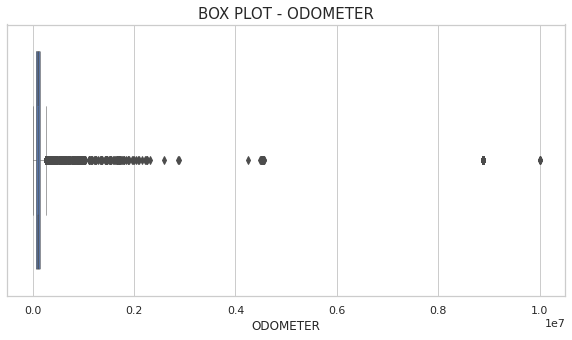

In [87]:
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))
ax = sns.boxplot(data = cars_sample_05 ,x = 'ODOMETER',hue = 'OVERALL_RESULT',showfliers=True,notch= True,width= 0.8,linewidth=0.5,orient='h')
plt.xlabel("ODOMETER", fontsize= 12)
#plt.ylabel("Passenger Age", fontsize= 12)
plt.title("BOX PLOT - ODOMETER", fontsize= 15)

In [88]:
cars_sample_05 = cars_sample_05[cars_sample_05['ODOMETER'] <= 270000]
cars_sample_05 = cars_sample_05[cars_sample_05['ODOMETER'] >= 1000]


In [89]:
cars_sample_05.shape

(136877, 16)

In [90]:
# Drop rows with null values
cars_sample_06 = cars_sample_05
cars_sample_06.dropna(inplace=True)
cars_sample_06.isnull().sum()

RecordID          0
VIN               0
GVWR              0
MODEL_YEAR        0
MAKE              0
MODEL             0
CYL               0
ENGINE_SIZE       0
TRANS_TYPE        0
DUAL_EXHAUST      0
ODOMETER          0
FUEL_TYPE         0
OVERALL_RESULT    0
TEST_EDATE        0
YEAR              0
AGE               0
dtype: int64

In [ ]:
#Export it
#cars_sample_06.to_csv(r"/content/drive/My Drive/Cars/Data/Car_ageclean.csv", index = False)
#cars_sample_06.to_csv(r"/content/drive/My Drive/Data/cars_sample_06.csv", index = False) #vincent

In [91]:
cars_sample_06.shape

(134315, 16)

In [92]:
# Remove rows according to Value count of MAKE 
# Get the count of each value
value_counts = cars_sample_06['MAKE'].value_counts()

# Select the values where the count is less than certain value
car_make_count_threshld = 850
to_remove = value_counts[value_counts <= car_make_count_threshld].index

# Keep rows where the city column is not in to_remove
cars_sample_06 = cars_sample_06[~cars_sample_06.MAKE.isin(to_remove)]

In [93]:
# New feature generation - MAKE_MODEL
cars_sample_06['MAKE_MODEL'] = cars_sample_06[['MAKE', 'MODEL']].agg('-'.join, axis=1)
cars_sample_06["MAKE_MODEL"] = cars_sample_06["MAKE_MODEL"].astype('category')

In [94]:
#Creating MAKE_MODEL_Label
#Label Encoder
cars_sample_06['MAKE_MODEL_Label'] = cars_sample_06['MAKE_MODEL'].cat.codes

In [ ]:
#Selecting columns for Make
#Select Required Columns
#list_columns=["MAKE_MODEL","AGE","OVERALL_RESULT"]
#cars_sample_07=cars_sample_06[list_columns]
#cars_sample_07.head()

In [ ]:
#Bin Age and GVWR
#cars_sample_06['GVWR_bin']=pd.cut(x = cars_sample_06['GVWR'], bins = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000], labels = [0,1,2,3,4,5,6,7,8,9])
# cars_sample_06['AGE_bin']=pd.cut(x = cars_sample_06['AGE'], bins = [0,5,10,15,20,25,30], labels = [0,1,2,3,4,5])

In [ ]:
#Selecting columns for Make
#Select Required Columns
#list_columns=["GVWR_bin","AGE_bin","OVERALL_RESULT"]
#cars_sample_07=cars_sample_06[list_columns]
#cars_sample_07.head()

In [ ]:
#cars_sample_06 has 135706 Rows and 16 Columns

In [95]:
#AGE, ODOMETER, MAKE_MODEL

#Select Required Columns
list_columns=["ODOMETER","AGE",'MODEL_YEAR','MAKE_MODEL',"OVERALL_RESULT"]
cars_sample_07=cars_sample_06[list_columns]
cars_sample_07.head()


,ODOMETER,AGE,MODEL_YEAR,MAKE_MODEL,OVERALL_RESULT
0,109025.0,15,1998,CHRYSLER-SEBRING,P
124100,190800.0,18,2000,DODGE-CARAVAN 2WD,P
124092,113955.0,17,2001,MITSUBISHI-GALANT,P
124094,78142.0,5,2013,CHEVROLET-IMPALA,P
124095,55075.0,15,2003,NISSAN-MURANO 2WD,P


In [96]:
cars_sample_07.OVERALL_RESULT.value_counts()

P    119553
F      9982
Name: OVERALL_RESULT, dtype: int64

In [97]:
cars_sample_07.shape

(129535, 5)

# ONE HOT ENCODING & SPLIT

In [98]:
# DONT run normalize section and split section if you use this section

#Create list with categorical features' names.
# ADD your categorcal feature names here
nonum_feats_names = ['MAKE_MODEL']

#Create list with numerical features' names.
# ADD your numerical feature names here
num_cols_names = ['ODOMETER', 'AGE','MODEL_YEAR','OVERALL_RESULT']

In [99]:
#Assign appropriate data type to categorical variables.
nonum_feats = cars_sample_07[nonum_feats_names].astype('category')
#nonum_feats.info()

In [100]:
# encode categorical variables
cat_dummies = pd.get_dummies(nonum_feats , drop_first=True)
#cat_dummies.info()

In [101]:
#Drop encoded feature from data, no need both
df_test_03 = cars_sample_07.drop(['MAKE_MODEL'], axis=1)
cars_encoded = pd.concat([df_test_03, cat_dummies], axis=1)
cars_encoded.head()

,ODOMETER,AGE,MODEL_YEAR,OVERALL_RESULT,MAKE_MODEL_ACURA-2.3CL,MAKE_MODEL_ACURA-2.5TL,MAKE_MODEL_ACURA-3.0CL,MAKE_MODEL_ACURA-3.2CL,MAKE_MODEL_ACURA-3.2TL,MAKE_MODEL_ACURA-3.5RL,MAKE_MODEL_ACURA-32S,MAKE_MODEL_ACURA-DRX,MAKE_MODEL_ACURA-ILX,MAKE_MODEL_ACURA-INTEGRA,MAKE_MODEL_ACURA-LEGEND,MAKE_MODEL_ACURA-MDX,MAKE_MODEL_ACURA-NSX,MAKE_MODEL_ACURA-Q40,MAKE_MODEL_ACURA-RDX,MAKE_MODEL_ACURA-RDXTURBO,MAKE_MODEL_ACURA-RL,MAKE_MODEL_ACURA-RLX,MAKE_MODEL_ACURA-RSX,MAKE_MODEL_ACURA-TL,MAKE_MODEL_ACURA-TLX,MAKE_MODEL_ACURA-TSX,MAKE_MODEL_ACURA-TSX SPORT WAGON,MAKE_MODEL_ACURA-VIGOR,MAKE_MODEL_ACURA-ZDX,MAKE_MODEL_BMW-1 SERIES,MAKE_MODEL_BMW-1-SERIES,MAKE_MODEL_BMW-128I,MAKE_MODEL_BMW-135I,MAKE_MODEL_BMW-228I,MAKE_MODEL_BMW-235I,MAKE_MODEL_BMW-3-SERIES,MAKE_MODEL_BMW-325E,MAKE_MODEL_BMW-325I,MAKE_MODEL_BMW-328,MAKE_MODEL_BMW-328 XI,...,MAKE_MODEL_VOLKSWAGEN-PICKUP,MAKE_MODEL_VOLKSWAGEN-R32,MAKE_MODEL_VOLKSWAGEN-RABBIT,MAKE_MODEL_VOLKSWAGEN-ROUTAN,MAKE_MODEL_VOLKSWAGEN-RV,MAKE_MODEL_VOLKSWAGEN-SCIROCCO,MAKE_MODEL_VOLKSWAGEN-TIGUAN,MAKE_MODEL_VOLKSWAGEN-TOUAREG,MAKE_MODEL_VOLKSWAGEN-VANAGON,MAKE_MODEL_VOLVO-240,MAKE_MODEL_VOLVO-740,MAKE_MODEL_VOLVO-760,MAKE_MODEL_VOLVO-800 SERIES,MAKE_MODEL_VOLVO-850,MAKE_MODEL_VOLVO-850 SERIES,MAKE_MODEL_VOLVO-940,MAKE_MODEL_VOLVO-960,MAKE_MODEL_VOLVO-C30,MAKE_MODEL_VOLVO-C70,MAKE_MODEL_VOLVO-DL,MAKE_MODEL_VOLVO-GLT,MAKE_MODEL_VOLVO-S40,MAKE_MODEL_VOLVO-S60,MAKE_MODEL_VOLVO-S60 AWD,MAKE_MODEL_VOLVO-S60 FWD,MAKE_MODEL_VOLVO-S70,MAKE_MODEL_VOLVO-S70 AWD,MAKE_MODEL_VOLVO-S70 SERIES SEDAN,MAKE_MODEL_VOLVO-S80,MAKE_MODEL_VOLVO-S90,MAKE_MODEL_VOLVO-V40,MAKE_MODEL_VOLVO-V50,MAKE_MODEL_VOLVO-V60,MAKE_MODEL_VOLVO-V70,MAKE_MODEL_VOLVO-V70 AWD,MAKE_MODEL_VOLVO-V70 FWD,MAKE_MODEL_VOLVO-V70XC,MAKE_MODEL_VOLVO-XC60,MAKE_MODEL_VOLVO-XC70,MAKE_MODEL_VOLVO-XC90
0,109025.0,15,1998,P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124100,190800.0,18,2000,P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124092,113955.0,17,2001,P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124094,78142.0,5,2013,P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124095,55075.0,15,2003,P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [102]:
#Dont run for random forest
# Quintile transformer
from sklearn.preprocessing import PowerTransformer
ptb = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
column_names_to_normalize = ['AGE','ODOMETER','MODEL_YEAR']
x = cars_encoded[column_names_to_normalize].values
x_scaled = ptb.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = cars_encoded.index)
cars_encoded[column_names_to_normalize] = df_temp
#works with odometer onlz KS test pass

In [103]:
#x is attributes, y is classifier
x=cars_encoded.drop('OVERALL_RESULT',axis=1)
y=cars_encoded.OVERALL_RESULT
# test and train split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=123)
print("X_train : ",x_train.shape)
print("X_test : ",x_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)
y_test = y_test.replace(['P'],[0])
y_test = y_test.replace(['F'],[1])
y_train = y_train.replace(['P'],[0])
y_train = y_train.replace(['F'],[1])


X_train :  (103628, 1558)
X_test :  (25907, 1558)
y_train :  (103628,)
y_test :  (25907,)


In [104]:
x_train.head()

,ODOMETER,AGE,MODEL_YEAR,MAKE_MODEL_ACURA-2.3CL,MAKE_MODEL_ACURA-2.5TL,MAKE_MODEL_ACURA-3.0CL,MAKE_MODEL_ACURA-3.2CL,MAKE_MODEL_ACURA-3.2TL,MAKE_MODEL_ACURA-3.5RL,MAKE_MODEL_ACURA-32S,MAKE_MODEL_ACURA-DRX,MAKE_MODEL_ACURA-ILX,MAKE_MODEL_ACURA-INTEGRA,MAKE_MODEL_ACURA-LEGEND,MAKE_MODEL_ACURA-MDX,MAKE_MODEL_ACURA-NSX,MAKE_MODEL_ACURA-Q40,MAKE_MODEL_ACURA-RDX,MAKE_MODEL_ACURA-RDXTURBO,MAKE_MODEL_ACURA-RL,MAKE_MODEL_ACURA-RLX,MAKE_MODEL_ACURA-RSX,MAKE_MODEL_ACURA-TL,MAKE_MODEL_ACURA-TLX,MAKE_MODEL_ACURA-TSX,MAKE_MODEL_ACURA-TSX SPORT WAGON,MAKE_MODEL_ACURA-VIGOR,MAKE_MODEL_ACURA-ZDX,MAKE_MODEL_BMW-1 SERIES,MAKE_MODEL_BMW-1-SERIES,MAKE_MODEL_BMW-128I,MAKE_MODEL_BMW-135I,MAKE_MODEL_BMW-228I,MAKE_MODEL_BMW-235I,MAKE_MODEL_BMW-3-SERIES,MAKE_MODEL_BMW-325E,MAKE_MODEL_BMW-325I,MAKE_MODEL_BMW-328,MAKE_MODEL_BMW-328 XI,MAKE_MODEL_BMW-3281,...,MAKE_MODEL_VOLKSWAGEN-PICKUP,MAKE_MODEL_VOLKSWAGEN-R32,MAKE_MODEL_VOLKSWAGEN-RABBIT,MAKE_MODEL_VOLKSWAGEN-ROUTAN,MAKE_MODEL_VOLKSWAGEN-RV,MAKE_MODEL_VOLKSWAGEN-SCIROCCO,MAKE_MODEL_VOLKSWAGEN-TIGUAN,MAKE_MODEL_VOLKSWAGEN-TOUAREG,MAKE_MODEL_VOLKSWAGEN-VANAGON,MAKE_MODEL_VOLVO-240,MAKE_MODEL_VOLVO-740,MAKE_MODEL_VOLVO-760,MAKE_MODEL_VOLVO-800 SERIES,MAKE_MODEL_VOLVO-850,MAKE_MODEL_VOLVO-850 SERIES,MAKE_MODEL_VOLVO-940,MAKE_MODEL_VOLVO-960,MAKE_MODEL_VOLVO-C30,MAKE_MODEL_VOLVO-C70,MAKE_MODEL_VOLVO-DL,MAKE_MODEL_VOLVO-GLT,MAKE_MODEL_VOLVO-S40,MAKE_MODEL_VOLVO-S60,MAKE_MODEL_VOLVO-S60 AWD,MAKE_MODEL_VOLVO-S60 FWD,MAKE_MODEL_VOLVO-S70,MAKE_MODEL_VOLVO-S70 AWD,MAKE_MODEL_VOLVO-S70 SERIES SEDAN,MAKE_MODEL_VOLVO-S80,MAKE_MODEL_VOLVO-S90,MAKE_MODEL_VOLVO-V40,MAKE_MODEL_VOLVO-V50,MAKE_MODEL_VOLVO-V60,MAKE_MODEL_VOLVO-V70,MAKE_MODEL_VOLVO-V70 AWD,MAKE_MODEL_VOLVO-V70 FWD,MAKE_MODEL_VOLVO-V70XC,MAKE_MODEL_VOLVO-XC60,MAKE_MODEL_VOLVO-XC70,MAKE_MODEL_VOLVO-XC90
119077,0.540586,0.849874,-0.738089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18742,-1.235183,-0.700711,0.080379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174978,-0.683109,-0.953493,1.767903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53003,-0.870135,0.989697,-1.159515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
182418,0.233174,0.389783,0.275694,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Normalize data

In [ ]:
# Run this when you dont have ONE HOT encoded features
# Quintile transformer
from sklearn.preprocessing import PowerTransformer
ptb = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
column_names_to_normalize = ['AGE','ODOMETER','GVWR']
x = cars_sample_07[column_names_to_normalize].values
x_scaled = ptb.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = cars_sample_07.index)
cars_sample_07[column_names_to_normalize] = df_temp
#works with odometer onlz KS test pass

In [ ]:
#Anderson-Darling Test
from scipy.stats import anderson
result = anderson(cars_sample_07['GVWR'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 65.093
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [ ]:
cars_sample_07.head()

,ODOMETER,AGE,GVWR,OVERALL_RESULT
0,-0.005475,0.700711,-1.107059,P
124100,1.313183,1.123415,0.286135,P
124092,0.078075,0.987652,-0.918498,P
124094,-0.579224,-1.310017,0.090704,P
124095,-1.096414,0.700711,0.227519,P


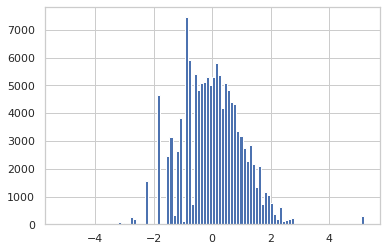

In [ ]:
import seaborn as sns
cars_sample_07['GVWR'].hist(bins=100)

# Split

In [ ]:
# Dont use this if use ONE HOT ENCODING , it data split code there also

In [ ]:
#x is attributes, y is classifier
x=cars_sample_07.drop('OVERALL_RESULT',axis=1)
y=cars_sample_07.OVERALL_RESULT
# test and train split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=123)
print("X_train : ",x_train.shape)
print("X_test : ",x_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)
y_test = y_test.replace(['P'],[0])
y_test = y_test.replace(['F'],[1])
y_train = y_train.replace(['P'],[0])
y_train = y_train.replace(['F'],[1])

X_train :  (103628, 5)
X_test :  (25907, 5)
y_train :  (103628,)
y_test :  (25907,)


# Case Balancing 


Select one case balancing method

In [105]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=42, replacement=True)
X_resampled, y_resampled = rus.fit_sample(x_train, y_train)

In [ ]:
# Over Sampling 
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(x_train, y_train)

In [ ]:
# SMOTE NC
# Use when there is categorical variables and have to definr which columns are categorical
smnc = SMOTENC(categorical_features= [2]  , random_state=100, sampling_strategy=.6)
X_resampled, y_resampled = smnc.fit_sample(x_train, y_train)

In [ ]:
# SMOTE
sm = SMOTE(sampling_strategy= 0.6, k_neighbors=5, random_state=100)
X_resampled, y_resampled = sm.fit_sample(x_train, y_train)

In [ ]:
# ADASYN
ada = ADASYN(random_state=100)
X_resampled, y_resampled = ada.fit_sample(x_train, y_train)

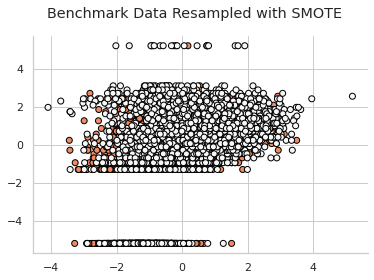

In [106]:
# Scatter plot
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, **kwarg_params)
sns.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")
pass

# Model - Random Forest

In [107]:
#Random Forest model "ODOMETER","AGE"
model= RandomForestClassifier(random_state = 42)

# Train the model on training data
model.fit(X_resampled,y_resampled)
#model.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [108]:
model.score(x_test,y_test)#accuracy


0.6190990851893311

In [109]:
#confusion matrix
y_predicted= model.predict(x_test)
cm= confusion_matrix(y_test,y_predicted)
cm

array([[14668,  9170],
       [  698,  1371]])

In [110]:
confusion = metrics.confusion_matrix(y_test,y_predicted)
TP = confusion[0,0]
TN = confusion[1,1]
FP = confusion[1,0]
FN = confusion[0,1]

print('TP :', TP)
print('TN :', TN)
print('FP :', FP)
print('FN :', FN)

print('Accuracy :',  metrics.accuracy_score(y_test,y_predicted))
print('Specificity :', TN/float(TN+FP))
print('FPR :',FP / float(TN+FP))
print('Recall :',TP/ float(TP+FN))
print('Precision :', TP / float(TP+FP))
print('NPV :',TN/float(FN+TN))
print('AUC :',roc_auc_score(y_test, y_predicted))

#F1_SCORE
Recall = TP/ float(TP+FN)
#print(Recall)
Precision = TP / float(TP+FP)
#print(Precision)
F1_Score = 2*(Precision*Recall)/ float(Precision+Recall)
print('F1_SCORE :',F1_Score)

TP : 14668
TN : 1371
FP : 698
FN : 9170
Accuracy : 0.6190990851893311
Specificity : 0.6626389560173997
FPR : 0.3373610439826003
Recall : 0.6153200771876836
Precision : 0.9545750357933099
NPV : 0.13006356133194194
AUC : 0.6389795166025416
F1_SCORE : 0.7482909907152332


In [111]:
#print(classification_report(y_test,y_predicted))
#print(accuracy_score(y_test, y_predicted))

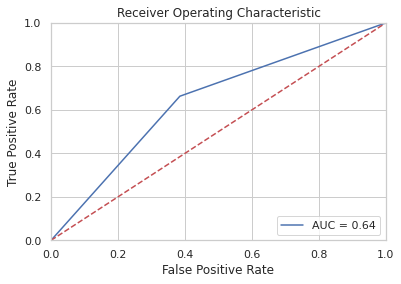

In [112]:
# ROC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#from sklearn.model_selection import GridSearchCV 
#grid_param = {
#    'n_estimators': [50,100, 150],
#    'criterion': ['gini', 'entropy'],
#    'bootstrap': [True, False]
#}
#gd_sr = GridSearchCV(estimator= model,
#                     param_grid=grid_param,
#                     scoring='accuracy',
#                     cv=5,
#                     n_jobs=-1)
#gd_sr.fit(x_train, y_train)
#best_parameters = gd_sr.best_params_
#print(best_parameters)
#Random Forest model "ODOMETER","AGE"
#model= RandomForestClassifier(n_estimators=50,bootstrap= True, criterion='entropy')
# Train the model on training data
#model.fit(X_resampled,y_resampled)


In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn import datasets
#from sklearn.ensemble import RandomForestClassifier
#from scipy.stats import uniform, truncnorm, randint

#Random Forest model "ODOMETER","AGE"
#model= RandomForestClassifier(n_estimators=100,bootstrap = True, criterion = 'gini')
#from sklearn.model_selection import cross_val_score

#Random Forest model "ODOMETER","AGE"
#RF= RandomForestClassifier(n_estimators=187,random_state = 42,criterion='gini',max_features= 0.286,min_samples_split= 0.153)


# Train the model on training data
#model.fit(X_resampled,y_resampled)2
#RF.fit(x_train, y_train )

In [ ]:
#model_params = {
    # randomly sample numbers from 4 to 204 estimators
    #'n_estimators': randint(50,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    #'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    #'min_samples_split': uniform(0.01, 0.199)
#}

In [ ]:
#create random forest classifier model
#rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
#clf = RandomizedSearchCV(RF, model_params, n_iter=100, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(x_train, y_train)

# print winning set of hyperparameters
#from pprint import pprint
#pprint(model.best_estimator_.get_params())

# Model - Decision Tree

In [ ]:
#DecisionTreeClassifier "ODOMETER","AGE","ENGINE_SIZE"
clf = DecisionTreeClassifier(random_state=42)
# Train the model
clf.fit(X_resampled,y_resampled)
clf.score(x_test,y_test)#accuracy

0.8674664052136801

In [ ]:
y_predicted= clf.predict(x_test)
#confusion matrix
cm= confusion_matrix(y_test,y_predicted)
cm

array([[29701,  2480],
       [ 2116,   381]])

In [ ]:
print(classification_report(y_test,y_predicted))
print(accuracy_score(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     32181
           1       0.13      0.15      0.14      2497

    accuracy                           0.87     34678
   macro avg       0.53      0.54      0.54     34678
weighted avg       0.88      0.87      0.87     34678

0.8674664052136801


In [ ]:
# AUC Score
roc_auc_score(y_test, y_predicted)

0.5377594967850361

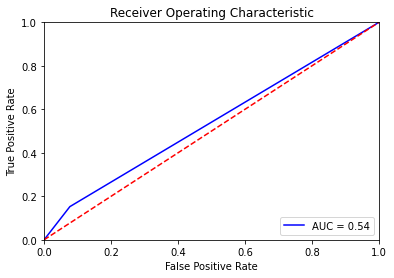

In [ ]:
# ROC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#heatmap for confusion matrix
#plt.figure(figsize=(10,7))
#sns.heatmap(cm,annot=True)
#plt.xlabel("Predicted")
#plt.ylabel("Truth")

# Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_resampled, y_resampled)


In [ ]:
clf.best_params_

{'C': 1.0}

In [ ]:
#Vincent code
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

parameters = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_resampled, y_resampled.ravel())

In [ ]:
clf.best_params_

{'C': 10, 'penalty': 'l2'}

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 0.1, penalty= 'l2' ,verbose=5,n_jobs=3,random_state=100)
#logreg = LogisticRegression(C=10, verbose=5,n_jobs=3,random_state=100)
#logreg = LogisticRegression(C=1.0, class_weight=None, dual=False,
                                         # fit_intercept=True,
                                         # intercept_scaling=1, l1_ratio=None,
                                         # max_iter=100, multi_class='auto',
                                          #n_jobs=None, penalty='l2',
                                         # random_state=None, solver='lbfgs',
                                         # tol=0.0001, verbose=5,
                                         # warm_start=False)
logreg.fit(X_resampled,y_resampled)
#logreg.fit(x_train,y_train)

logreg.score(x_test,y_test)#accuracy

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed: 20.7min finished


0.6500173698228278

In [ ]:
print(logreg.coef_)  

[[ 0.46353248  0.02665676 -0.37406911 ...  0.328182   -0.08624923
  -0.20914926]]


In [ ]:
print(logreg.intercept_)

[-0.23834061]


In [ ]:
y_predicted= logreg.predict(x_test)
#confusion matrix
lm= confusion_matrix(y_test,y_predicted)
lm

array([[15437,  8401],
       [  666,  1403]])

In [ ]:
pred_proba_df = pd.DataFrame(clf.predict_proba(x_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n**** For i = {} **'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1)))

NameError: ignored

In [ ]:
#print(classification_report(y_test,y_predicted))
#print(accuracy_score(y_test, y_predicted))

In [ ]:
confusion = metrics.confusion_matrix(y_test,y_predicted)
TP = confusion[0,0]
TN = confusion[1,1]
FP = confusion[1,0]
FN = confusion[0,1]

print('TP :', TP)
print('TN :', TN)
print('FP :', FP)
print('FN :', FN)

print('Accuracy :',  metrics.accuracy_score(y_test,y_predicted))
print('Specificity :', TN/float(TN+FP))
print('FPR :',FP / float(TN+FP))
print('Recall :',TP/ float(TP+FN))
print('Precision :', TP / float(TP+FP))
print('NPV :',TN/float(FN+TN))
print('AUC :',roc_auc_score(y_test, y_predicted))

#F1_SCORE
Recall = TP/ float(TP+FN)
#print(Recall)
Precision = TP / float(TP+FP)
#print(Precision)
F1_Score = 2*(Precision*Recall)/ float(Precision+Recall)
print('F1_SCORE :',F1_Score)

TP : 15437
TN : 1403
FP : 666
FN : 8401
Accuracy : 0.6500173698228278
Specificity : 0.6781053649105848
FPR : 0.3218946350894152
Recall : 0.6475794949240709
Precision : 0.9586412469726138
NPV : 0.1431048551611587
AUC : 0.6628424299173278
F1_SCORE : 0.772990160486718


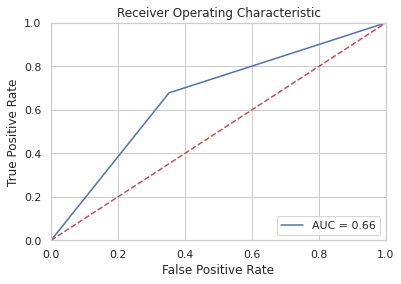

In [ ]:
# ROC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# AUC Score
roc_auc_score(y_test, y_predicted)

0.5996878580025813

In [ ]:
tmp = logreg.fit(X_resampled,y_resampled.ravel())

In [ ]:
y_pred_sample_score = tmp.decision_function(x_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()